### Monte Carlo sampling experiments

[Geometric Brownian asset model](#cell1)\
[Simpler approach with correlated errors](#cell2)

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [2]:
# Basic functions to read/write .csvs

#Standard columns in the processed data files
ref_columns=['Country','Entity','Parameter','Year','Period','Value','Unit','Reference','Priority','Note']

def read_data(file):

    #Make sure header is read properly, in case file was manually edited
    i=2
    orig=pd.read_csv(file, header=i)
    while set(orig.columns) != set(ref_columns):
        orig=pd.read_csv(file, header=i)
        i+=1
        
    if set(orig.columns) == set(ref_columns):
        #Return dataframe indexed by parameter and year
        orig.set_index(['Parameter','Year'],inplace=True)
        
        return orig

    else:
        raise Exception('Wrong format')

    
def write_data(data, data_name, file):
    
    data.reset_index(inplace=True)
    try:
        data=data[ref_columns]
        directory = os.path.dirname(file)
        if not os.path.exists(directory):
            print('Creating path {}'.format(directory))
            os.makedirs(directory)
        
        data.to_csv(file,index=False)

        header='Name: {0}'.format(data_name)+ \
        '\nDate: {0}'.format(str(datetime.datetime.today()))+ \
        '\nAuthor: {0}\n'.format(pwd.getpwuid(os.getuid())[4])

        with open(file, 'r+') as f:
            content = f.read()
            f.seek(0, 0)
            f.write(header+'\n'+content)   
    
    except Exception as e:
        print(e)

In [3]:
#Reference wind and PV data
ref_pv=read_data('./AUT/Technologies/AUT_PV.csv').loc[('Inv',slice(None)),'Value'].astype(float).values
ref_wind=read_data('./AUT/Technologies/AUT_OnshoreWind.csv').loc[('Inv',slice(None)),'Value'].astype(float).values
ref_pv = ref_pv[:-1]
ref_wind = ref_wind[:-1]

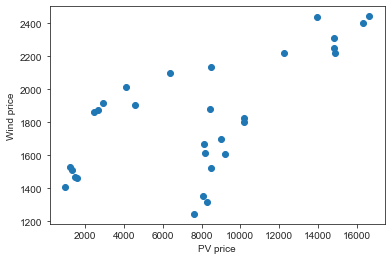

0.6583182819881191


In [4]:
#Correlation between PV and wind annual price
fig, ax = plt.subplots(1)

ax.scatter(ref_pv,ref_wind)
ax.set_xlabel('PV price')
ax.set_ylabel('Wind price')
plt.show()

corr=scipy.stats.pearsonr(ref_pv, ref_wind)[0]
print(corr)

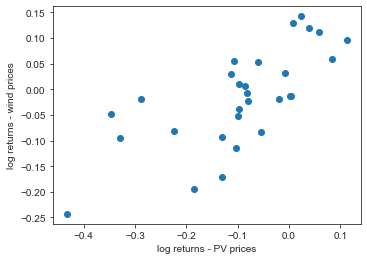

0.713620082880474


In [5]:
#Correlation between log annual price changes ("returns") for PV and wind
fig, ax = plt.subplots(1)

ax.scatter(np.log(ref_pv[1:]/ref_pv[:-1]),
           np.log(ref_wind[1:]/ref_wind[:-1]))
ax.set_aspect('equal')
ax.set_xlabel('log returns - PV prices')
ax.set_ylabel('log returns - wind prices')
plt.show()

corr=scipy.stats.pearsonr(np.log(ref_pv[1:]/ref_pv[:-1]),
                          np.log(ref_wind[1:]/ref_wind[:-1]))[0]
print(corr)

 ### <a id="cell1"></a> Geometric Brownian asset model
 
 Adapted from https://medium.com/codex/simulate-multi-asset-baskets-with-correlated-price-paths-using-python-472cbec4e379

In [8]:
#Try with specified correlation between annual returns for PV and wind
corr=scipy.stats.pearsonr(np.log(ref_pv[1:]/ref_pv[:-1]),
                          np.log(ref_wind[1:]/ref_wind[:-1]))[0]

corr_matrix=np.array([[1,corr],
                      [corr,1]])

technologies=[ref_pv, ref_wind] #Reference time series
n_tech=len(technologies)
n_scen=50 #Sample 50 scenarios, each scenario includes time series for the two technologies

# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(corr_matrix)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

T = len(ref_pv) # Number of simulated periods
dt = 1./(T) # 1/(T-1)?

# Log annual "returns" (annual change in price) for each tech
log_returns=[np.log(tech[1:]/tech[:-1]) for tech in technologies]
# Volatility over the complete simulated period for each tech
volatility=np.std(log_returns,axis=1)*np.sqrt(T-1)

# Sum of log annual changes for each tech
r = [np.sum(np.log(tech[1:]/tech[:-1])) for tech in technologies]


In [9]:
print(volatility)
print(r)
#PV has greater variation and stronger negative trend

[0.69098308 0.5056704 ]
[-2.7423100081799556, -0.466098703132491]


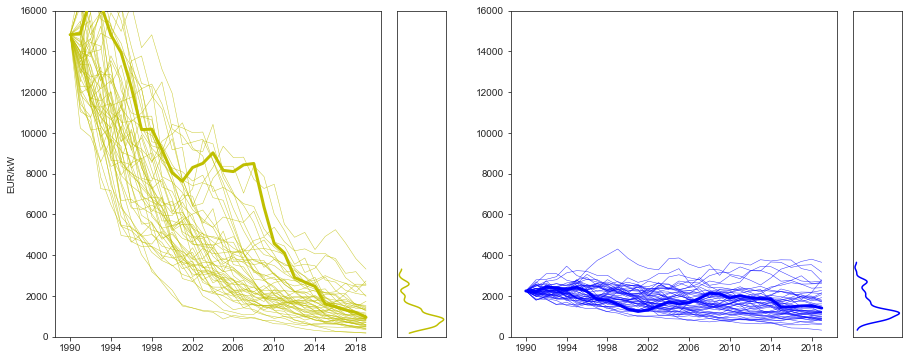

In [10]:
scenarios=[]

np.random.seed(1)

for s in range(n_scen):
    value_array = np.zeros((n_tech,T)) #Arrays of annual prices
    value_array[:,0]=[ref_pv[0], ref_wind[0]] # First value is initial reference value
    
    for t in range(1, T):
        # Generate array of random standard normal draws
        random_array = np.random.standard_normal(n_tech)

        # Multiply R (from factorization) with random_array to obtain correlated errors
        epsilon_array = np.inner(random_array,R)

        # Sample a price for each technology
        for n in range(n_tech):
            S = value_array[n,t-1]
            # Generate new price
            value_array[n,t] = S*np.exp((r[n]-0.5*volatility[n]**2)*dt + volatility[n]*np.sqrt(dt)*epsilon_array[n])
            
    scenarios.append(value_array)

    
fig, ax = plt.subplots(1,n_tech)
scenarios=np.array(scenarios)

tech_colors=['y','b']

for t in range(n_tech):
    for s in range(n_scen):
        ax[t].plot(scenarios[s,t],
                c=tech_colors[t],
                lw=0.5, alpha=0.8)
        
    ax[t].plot(technologies[t], c=tech_colors[t], lw=3.,zorder=1e6)
    ax[t].set_ylim([0,16000])
    ax[t].set_xticks(np.arange(0,30,4))
    ax[t].set_xticklabels(np.arange(1990,2020,4))
    ax2 = ax[t].inset_axes([1.05, 0.0, 0.15, 1.])
    
    X=np.linspace(np.min(scenarios[:,t,-1]), np.max(scenarios[:,t,-1]), 100)
    kernel = scipy.stats.gaussian_kde(scenarios[:,t,-1], bw_method=0.2)
    ax2.plot(kernel(X), X, c=tech_colors[t])
    ax2.set_ylim([0,16000])
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    
ax[0].set_ylabel('EUR/kW')

fig.set_size_inches(14,6)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [11]:
# Check that average correlations of log annual changes ("returns") and prices in the synthetic scenarios
# are close to original values

log_returns_corrs=[]
annual_price_corrs=[]
volatilities=[]

for s in range(n_scen):

    log_returns_corrs.append(scipy.stats.pearsonr(np.log(scenarios[s][0,1:]/scenarios[s][0,:-1]),
                                      np.log(scenarios[s][1,1:]/scenarios[s][1,:-1]))[0])
    annual_price_corrs.append(scipy.stats.pearsonr(scenarios[s,0],scenarios[s,1])[0])
    
print(np.mean(log_returns_corrs)) #Original: 0.714
print(np.mean(annual_price_corrs)) #Original: 0.658

0.6994828562430894
0.6337342899726793


In [12]:
# Check that volatilities per technology are close to original value

volatilities=[]

for s in range(n_scen):
    log_returns=[np.log(scenarios[s][t,1:]/scenarios[s][t,:-1]) for t in range(n_tech)] #Log annual "returns" (annual change in price) for each tech
    s_volatility=np.std(log_returns,axis=1)*np.sqrt(T-1) #Volatility over the complete simulated period for each tech in the scenario
    volatilities.append(s_volatility)
    
print(np.array(volatilities).mean(axis=0)) #Original: [0.69098308 0.5056704 ]

[0.66852034 0.47577974]


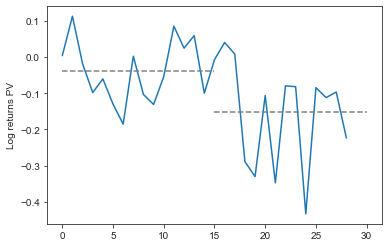

In [14]:
fig, ax = plt.subplots(1)
log_changes=np.log(ref_pv[1:]/ref_pv[:-1])

ax.plot(log_changes)
ax.plot([0,T/2],[np.mean(log_changes[:int(T/2)])]*2,c='gray',ls='--')
ax.plot([T/2,T],[np.mean(log_changes[int(T/2):])]*2,c='gray',ls='--')
ax.set_ylabel('Log returns PV')
plt.show()

# With this approach, should probably use different r and volatility in each decade to
# capture different trends/non-stationarity

### <a id="cell2"></a> Simpler approach with correlated random errors applied to original time series

In [15]:
No_slices = 30

### Create correlated 2*30 random errors: correlated random errors between pv cost and wind cost in 30 years
Mean_MC=0; # mean of variance in costs
Std_MC=0.1; # standard deviation of variance in costs (3*sigma = 0.3 so we could have a variation range around +-30%)
Cor_MC=0.8; # correlation coefficient between two technology costs
Random = {}

par_cov=Std_MC**2 #SD1*SD2
par_sigma=[[par_cov,Cor_MC*par_cov],
           [Cor_MC*par_cov,par_cov]]
par_mean=[0,0]
np.random.seed(0)
Random[0] = np.random.multivariate_normal(par_mean,par_sigma, (30,), 'raise')   # 


### Create correlated 30*2 random errors: (auto)correlated random errors for 30 time steps for two vairaibles
Mean_MC=0; # mean of variance in costs
Std_MC=0.05; # standard deviation of variance in costs
Cor_MC=0.6; # correlation coefficient between time slices for costs
Random_2 = {}

par_mean=np.zeros((No_slices))
par_sigma=np.zeros((No_slices, No_slices)) 
for i in range(0, No_slices):
    par_mean[i]=Mean_MC
    for j in range(0, No_slices):
        if i==j:
            par_sigma[i,j]=Std_MC**2 #SD1*SD2
        else:
            par_sigma[i,j]=Std_MC**2*Cor_MC #SD1*SD1*cor
            
np.random.seed(40)
Random_2[0] = np.random.multivariate_normal(par_mean,par_sigma, (2,), 'raise')   # nx2

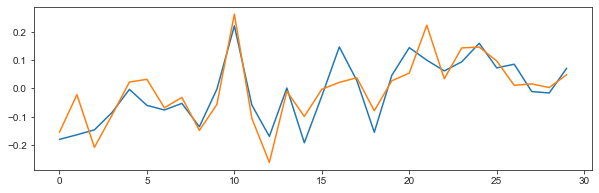

In [16]:
## Correlated random errors for two costs : correlations between two techn
figure, ax1=plt.subplots(1,1,figsize=(10, 3))
ax1.plot(np.arange(0,30,1),Random[0][:,0])

ax1.plot(np.arange(0,30,1),Random[0][:,1])
plt.show()

In [18]:
scipy.stats.pearsonr(Random[0][:,0],Random[0][:,1])

(0.6872406100373593, 2.727930054458837e-05)

In [17]:
### Generate 100 scenarios

No_slices = 30

Random = {}
Random_2 = {}
cost_a_error = {}
cost_b_error = {}
for k in range(100):
    np.random.seed(k)
    Mean_MC=0; # mean of variance in costs
    Std_MC=0.1; # standard deviation of variance in costs
    Cor_MC=0.6; # correlation coefficient between time slices for costs
    par_cov=Std_MC**2 #SD1*SD2
    par_sigma=[[par_cov,Cor_MC*par_cov],
               [Cor_MC*par_cov,par_cov]]
    par_mean=[0,0]
    
    Random[k] = np.random.multivariate_normal(par_mean,par_sigma, (30,), 'raise')   # 


    Mean_MC=0; # mean of variance in costs
    Std_MC=0.05; # standard deviation of variance in costs
    Cor_MC=0.8; # correlation coefficient between time slices for costs
    par_mean=np.zeros((No_slices))
    par_sigma=np.zeros((No_slices, No_slices)) 
    for i in range(0, No_slices):
        par_mean[i]=Mean_MC
        for j in range(0, No_slices):
            if i==j:
                par_sigma[i,j]=Std_MC**2 #SD1*SD2
            else:
                par_sigma[i,j]=Std_MC**2*Cor_MC #SD1*SD1*cor

    Random_2[k] = np.random.multivariate_normal(par_mean,par_sigma, (2,), 'raise')   # nx2
    
    cost_a_error[k] = Random[k][:,0] + Random_2[k][0]
    cost_b_error[k] = Random[k][:,1] + Random_2[k][1]

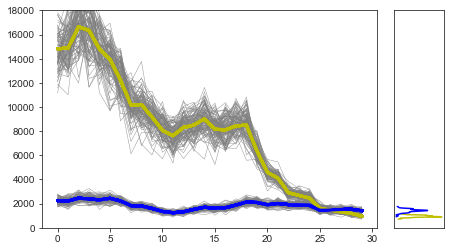

In [20]:
scenarios_pv=[]
scenarios_wind=[]
fig, ax = plt.subplots(1)
for k in range(100):
    scenarios_pv.append(ref_pv*(1+cost_a_error[k]))
    scenarios_wind.append(ref_wind*(1+cost_b_error[k]))
    ax.plot(scenarios_pv[k],c='gray',lw=0.5,alpha=0.8)
    ax.plot(ref_pv,c='y',lw=3.)
    ax.plot(scenarios_wind[k],c='gray',lw=0.5,alpha=0.8)
    ax.plot(ref_wind,c='b',lw=3.)
    
    
scenarios_pv=np.array(scenarios_pv)
scenarios_wind=np.array(scenarios_wind)
ax2 = ax.inset_axes([1.05, 0.0, 0.15, 1.])


X=np.linspace(np.min(scenarios_pv[:,-1]),np.max(scenarios_pv[:,-1]),100)
kernel = scipy.stats.gaussian_kde(scenarios_pv[:,-1],bw_method=0.2)
ax2.plot(kernel(X),X,c='y')
X=np.linspace(np.min(scenarios_wind[:,-1]),np.max(scenarios_wind[:,-1]),100)
kernel = scipy.stats.gaussian_kde(scenarios_wind[:,-1],bw_method=0.2)
ax2.plot(kernel(X),X,c='b')

ax.set_ylim([0,18000])
ax2.set_ylim([0,18000])
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

plt.show()

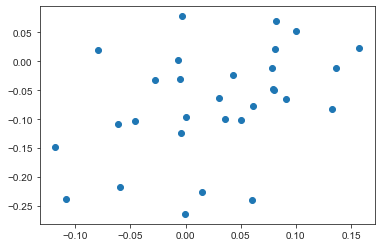

In [21]:
plt.scatter(cost_a_error[1],cost_b_error[1])

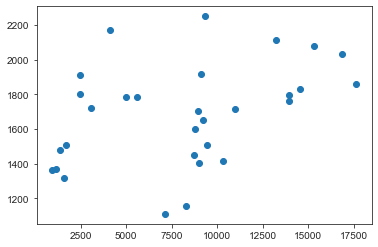

In [22]:
plt.scatter(scenarios_pv[1],scenarios_wind[1])

In [27]:
corrs=[]
for k in range(100):
    corrs.append(scipy.stats.pearsonr(cost_a_error[k],cost_b_error[k])[0])
print(np.mean(corrs))

0.5426710821023624


In [26]:
corrs=[]
for k in range(100):
    corrs.append(scipy.stats.pearsonr(scenarios_pv[k],scenarios_wind[k])[0])
print(np.mean(corrs))

0.6063344549172095
